<a href="https://colab.research.google.com/github/gioliveirass/fatec-AM-airPollutionLevel/blob/main/air_pollution_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💨 Importando bibliotecas

Importando bibliotecas que serão utilizadas ao longo do desenvolvimento do script.

In [9]:
# Pandas
import pandas as pd

In [76]:
# Numpy
import numpy as np

In [10]:
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [11]:
# Sklearn
from sklearn.ensemble import RandomForestRegressor

In [12]:
# Skforecast
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 💨 Carregando base de dados

A base de dados utilizada se encontra disponível no [Kaggle](https://www.kaggle.com/datasets/totoro29/air-pollution-level/).

In [13]:
url = 'https://raw.githubusercontent.com/gioliveirass/fatec-AM-airPollutionLevel/main/Air%20Pollution.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
0,Afghanistan,Kabul,2019,119.77,NaN,NaN,18.0,NaN,NaN,2022
1,Albania,Durres,2015,NaN,17.65,26.63,NaN,NaN,83.961187,2022
2,Albania,Durres,2016,14.32,24.56,24.78,NaN,NaN,87.932605,2022
3,Albania,Elbasan,2015,NaN,NaN,23.96,NaN,NaN,97.853881,2022
4,Albania,Elbasan,2016,NaN,NaN,26.26,NaN,NaN,96.049636,2022


## 💨 Selecionando valores relevantes

Queremos prever o nível da poluição do ar apenas da cidade de São Paulo - Brasil. Além do mais, vamos utilizar somente as partículas de poluição atmosférica PM2.5 (μg/m3) para realizar a predição de nível de poluição do ar.

In [14]:
# Aplicando filtro de país nos dados
country_filter = data["Country Name"] == "Brazil"
filtered_data = data[country_filter]
filtered_data.head(5)

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
1864,Brazil,Americana,2011,NaN,37.0,NaN,NaN,NaN,NaN,2018
1865,Brazil,Americana,2012,NaN,34.0,NaN,NaN,NaN,NaN,2018
1866,Brazil,Americana,2013,NaN,33.0,NaN,NaN,NaN,NaN,2018
1867,Brazil,Americana,2014,NaN,36.0,NaN,NaN,NaN,NaN,2018
1868,Brazil,Americana,2016,NaN,36.0,NaN,NaN,NaN,NaN,2018


In [15]:
# Aplicando o filtro de cidade nos dados
city_filter = filtered_data["City"] == "Sao Paulo"
filtered_data = filtered_data[city_filter]
filtered_data.head()

,Country Name,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Updated Year
2271,Brazil,Sao Paulo,2010,17.33,36.62,49.17,NaN,NaN,NaN,2018
2272,Brazil,Sao Paulo,2011,20.25,36.50,42.33,NaN,NaN,NaN,2018
2273,Brazil,Sao Paulo,2012,17.50,34.90,42.33,NaN,NaN,NaN,2018
2274,Brazil,Sao Paulo,2013,16.00,32.73,36.78,NaN,NaN,NaN,2018
2275,Brazil,Sao Paulo,2014,19.14,34.86,39.70,NaN,NaN,NaN,2018


In [16]:
# Removendo colunas que não serão utilizadas
columns_to_remove = ['Country Name', 'City', 'PM10 (μg/m3)', 'NO2 (μg/m3)', 'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)', 'NO2 temporal coverage (%)', 'Updated Year']
filtered_data = filtered_data.drop(columns_to_remove, axis=1)
filtered_data.head()

,Year,PM2.5 (μg/m3)
2271,2010,17.33
2272,2011,20.25
2273,2012,17.50
2274,2013,16.00
2275,2014,19.14


## 💨 Identificando se há algum ruído nos dados filtrados

Se algum ruído (exemplo: valores nulos) for identificado, ele deve ser removido.

In [17]:
# Identificando tipo de valores
filtered_data.dtypes

Year               int64
PM2.5 (μg/m3)    float64
dtype: object

In [18]:
# Identificando se há algum valor nulo
print(filtered_data.isnull().sum())

Year             0
PM2.5 (μg/m3)    0
dtype: int64


## 💨 Ajustando dados


In [46]:
# Converte data de string para datetime e transforma em índice
filtered_data['Year'] = pd.to_datetime(filtered_data['Year'], format='%Y')
sorted_data = filtered_data.set_index('Year')
sorted_data = sorted_data.asfreq('ys')
sorted_data = sorted_data.sort_index()
sorted_data.head

<bound method NDFrame.head of             PM2.5 (μg/m3)
Year                     
2010-01-01          17.33
2011-01-01          20.25
2012-01-01          17.50
2013-01-01          16.00
2014-01-01          19.14
2015-01-01          18.40
2016-01-01          16.60
2017-01-01            NaN
2018-01-01          17.26
2019-01-01          16.67>

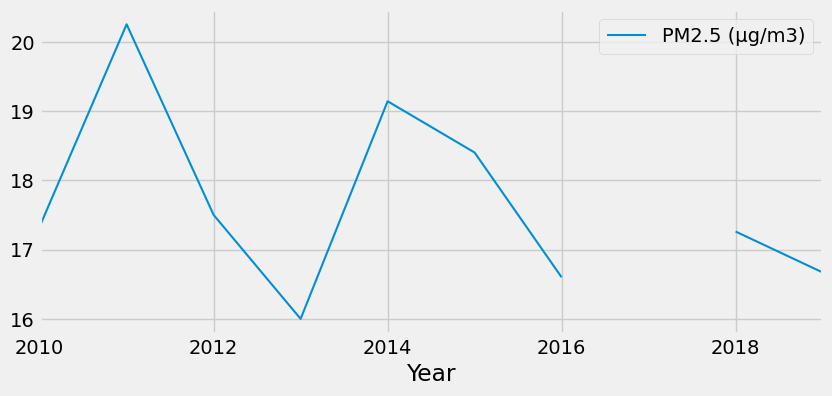

In [47]:
# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
sorted_data['PM2.5 (μg/m3)'].plot(ax=ax, label='PM2.5 (μg/m3)')
ax.legend();

In [48]:
print(f'Number of rows with missing values: {sorted_data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.1


In [75]:
# Código para verificar se não existem "buracos" nos dados
(sorted_data.index == pd.date_range(start=sorted_data.index.min(),
                             end=sorted_data.index.max(),
                             freq=sorted_data.index.freq)).all()

True

In [77]:
# Em caso de buracos, podemos preencher os valores (Importante: verificar a frequência)
sorted_data.asfreq(freq='ys', fill_value=np.nan)

,PM2.5 (μg/m3)
Year,
2010-01-01,17.33
2011-01-01,20.25
2012-01-01,17.50
2013-01-01,16.00
2014-01-01,19.14
2015-01-01,18.40
2016-01-01,16.60
2017-01-01,NaN
2018-01-01,17.26


## 💨 Separando dados de teste

In [83]:
# Divide dados em treinamento e teste
steps = 6
data_train = sorted_data[:-steps]
data_test  = sorted_data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2010-01-01 00:00:00 --- 2013-01-01 00:00:00  (n=4)
Test dates  : 2014-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=6)


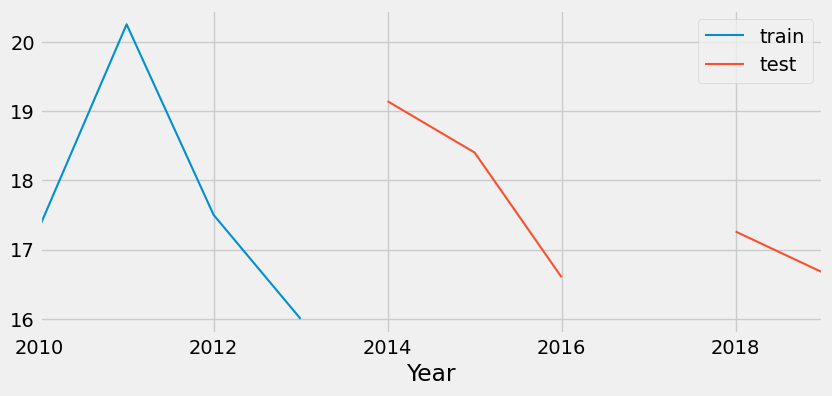

In [84]:
# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['PM2.5 (μg/m3)'].plot(ax=ax, label='train')
data_test['PM2.5 (μg/m3)'].plot(ax=ax, label='test')
ax.legend();

## 💨 Configurando e realizando a predição

In [97]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 1
             )

forecaster.fit(y=data_train['PM2.5 (μg/m3)'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: AS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-11 12:57:31 
Last fit date: 2023-04-11 12:57:31 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: N

In [98]:
# Faz predição no conjunto de teste
steps = 6
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2014-01-01    18.920
2015-01-01    17.105
2016-01-01    18.920
2017-01-01    17.105
2018-01-01    18.920
Freq: AS-JAN, Name: pred, dtype: float64

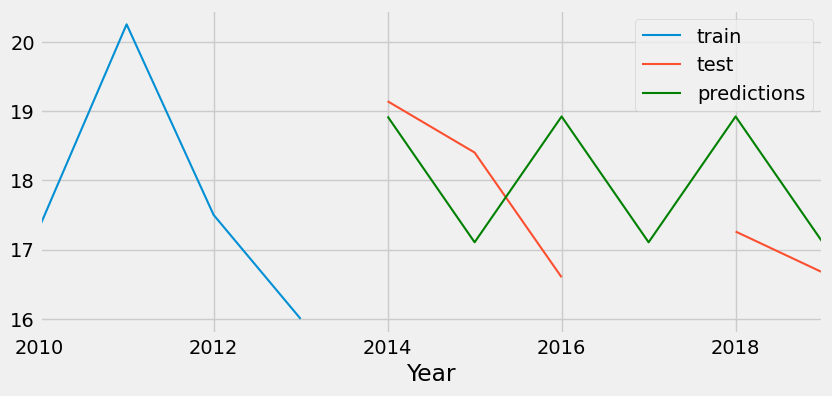

In [99]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['PM2.5 (μg/m3)'].plot(ax=ax, label='train')
data_test['PM2.5 (μg/m3)'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();